## Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os

In [3]:
#Victor Path
%cd /content/drive/MyDrive/EPFL/ADA-2023/ada-2023-project-thedogues1815

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-400-c9dc2f89ca24>", line 2, in <cell line: 2>
    get_ipython().run_line_magic('cd', '/content/drive/MyDrive/EPFL/ADA-2023/ada-2023-project-thedogues1815')
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/

In [4]:
#PabbyDaddy Path
%cd /content/drive/MyDrive/ADA/ada-2023-project-thedogues1815

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-400-7ee28be6d069>", line 2, in <cell line: 2>
    get_ipython().run_line_magic('cd', '/content/drive/MyDrive/ADA/ada-2023-project-thedogues1815')
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10

## Libraries

In [141]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import itertools
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [142]:
NEWS_COLLECTION_PATH = 'Usable_data/version_2/news_dataset_cl.csv'
csv_eng = pd.read_csv(NEWS_COLLECTION_PATH)

In [143]:
WIKI_PATH = 'data/wiki_pageviews_covid-master/data/topics_linked.csv'
wiki_topics = pd.read_csv(WIKI_PATH)

## Key word extraction

In [325]:
import string as string

def remove_punctuation(text):
    # Create a translation table to remove punctuation
    translator = str.maketrans('', '', string.punctuation)

    # Remove punctuation from the text
    text_without_punctuation = text.translate(translator)

    return text_without_punctuation

def extract_keyword_noun(text):
    # Tokenize the text preserving case since it's important for recognizing proper nouns
    text = remove_punctuation(text)

    tokens = word_tokenize(text)

    # POS tagging using the case-sensitive tokens
    pos_tags = nltk.pos_tag(tokens)

    # Create a list to store keywords
    keywords = []
    current_phrase = []

    # Define POS tags for words to exclude
    excluded_pos_tags = ['DT', 'IN', 'CC']

    for word, tag in pos_tags:
        # Check if the word is a proper noun or a verb
        if tag in ['NNP', 'NNPS']:
            current_phrase.append(word)
        elif tag.startswith('VB'):
            # If the word is a verb, we skip adding it to the keywords
            continue
        elif tag in excluded_pos_tags:
            # If the word has an excluded POS tag, skip adding it to the keywords
            continue
        else:
            # Check if we have a current phrase
            if current_phrase:
                # Join the current phrase to form a proper noun and append to keywords
                keywords.append(' '.join(current_phrase))
                current_phrase = []  # Reset the current phrase

            # If the word is not a stop word, is alphabetic, and not a verb, add it as a keyword
            if word.lower() not in stopwords.words('english') and nltk.pos_tag([word])[0][1].startswith('V'):
              continue

            else:
              keywords.append(word)


    # Check if there's any phrase left in the buffer
    if current_phrase:
        keywords.append(' '.join(current_phrase))

    return np.array(keywords)

### Check results

In [145]:
csv_eng['keywords_noun'] = csv_eng['claim'].apply(extract_keyword_noun)

In [146]:
csv_eng['claim'].iloc[14]

' A video purporting to show several dead bodies lying beside coronavirus patients in a hospital ward has been viewed thousands of times in multiple posts on Facebook and Twitter alongside a claim it was filmed in the Indian capital of Delhi.'

In [147]:
csv_eng['keywords_noun'].iloc[14]

array(['video', 'several', 'dead', 'bodies', 'beside', 'coronavirus',
       'patients', 'hospital', 'ward', 'thousands', 'times', 'multiple',
       'posts', 'Facebook Twitter', 'claim', 'Indian', 'capital', 'Delhi'],
      dtype='<U16')

### Check frequency of keywords

In [148]:
# Flatten the list of keywords and count the frequencies
all_keywords = list(itertools.chain(*csv_eng['keywords_noun']))
keyword_counts = Counter(all_keywords)

# Convert the counts to a DataFrame
keyword_freq_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Frequency'])

# Sort the DataFrame by frequency in descending order
keyword_freq_df = keyword_freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

In [149]:
view_df = keyword_freq_df[keyword_freq_df["Frequency"] > 0]
view_df.shape
view_df

,Keyword,Frequency
0,coronavirus,635
1,COVID-19,365
2,people,174
3,times,168
4,novel,160
...,...,...
3814,ulcer,1
3815,Sweden,1
3816,Denmark Norway,1
3817,LEGITFUND.COM,1


In [150]:
view_df[view_df["Keyword"] == 'Since']

,Keyword,Frequency


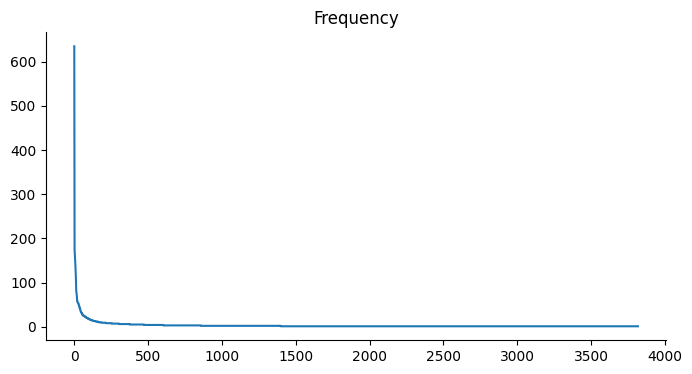

In [151]:
from matplotlib import pyplot as plt
view_df['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

### Comparison of key word extraction methods

In [152]:
csv_eng['statement'][43]

'stacey georgias abrams tre gets reopening covid'

In [153]:
csv_eng['claim'][43]

' “Since the reopening of (the state of Georgia), we’ve seen our COVID rate skyrocket by 40%.”'

In [154]:
keyWordList = extract_keyword_noun(csv_eng['claim'][43])

textGoogle = ' '.join(keyWordList) + " wikipedia"

In [155]:
textGoogle

'reopening state Georgia COVID rate skyrocket wikipedia'

## Fetching wikipedia articles

In [156]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=f823858307da21b4ea478161ffdac9cfc8f56fc8b170e5f8a58968cf5821df78
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


### Similarity between two strings (abandonned)

In [157]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import wikipedia

def get_wikipedia_content(title):
    try:
        page = wikipedia.page(title)
        return page.content
    except wikipedia.DisambiguationError as e:
        # Handle disambiguation pages if needed
        print(f"DisambiguationError: {e}")
    except wikipedia.HTTPTimeoutError as e:
        print(f"HTTPTimeoutError: {e}")
    except wikipedia.PageError as e:
        print(f"PageError: {e}")
    return None

def extract_correlated_articles(fake_news_claim, wikipedia_articles):
    correlated_articles = []

    # Vectorize the fake news claim
    vectorizer = TfidfVectorizer()
    fake_news_vector = vectorizer.fit_transform([fake_news_claim])

    for article_title in wikipedia_articles:
        # Get the content of the Wikipedia article
        article_content = get_wikipedia_content(article_title)

        if article_content:
            # Vectorize the Wikipedia article content
            article_vector = vectorizer.transform([article_content])

            # Calculate cosine similarity
            similarity_score = cosine_similarity(fake_news_vector, article_vector)[0][0]

            # If similarity is above a certain threshold (e.g., 0.5), consider it correlated
            if similarity_score > 0.5:
                correlated_articles.append((article_title, similarity_score))

    # Sort the correlated articles by similarity score in descending order
    correlated_articles = sorted(correlated_articles, key=lambda x: x[1], reverse=True)

    return correlated_articles

# Example usage:
fake_news_claim = "Climate change is a hoax. I love to eat Barbecue"
wikipedia_articles = ["COVID-19 misinformation"]

result = extract_correlated_articles(fake_news_claim, wikipedia_articles)

In [158]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import wikipedia

def extract_correlated_articles(fake_news_claim, wikipedia_articles):
    def get_wikipedia_content(title):
        try:
            page = wikipedia.page(title)
            return page.content
        except wikipedia.DisambiguationError as e:
            print(f"DisambiguationError: {e}")
        except wikipedia.HTTPTimeoutError as e:
            print(f"HTTPTimeoutError: {e}")
        except wikipedia.PageError as e:
            print(f"PageError: {e}")
        return None

    correlated_articles = []

    # Vectorize the fake news claim
    vectorizer = TfidfVectorizer()
    fake_news_vector = vectorizer.fit_transform([fake_news_claim])

    for article_title in wikipedia_articles:
        # Get the content of the Wikipedia article
        article_content = get_wikipedia_content(article_title)

        if article_content:
            # Vectorize the Wikipedia article content
            article_vector = vectorizer.transform([article_content])

            # Calculate cosine similarity
            similarity_score = cosine_similarity(fake_news_vector, article_vector)[0][0]

            # If similarity is above a certain threshold (e.g., 0.5), consider it correlated
            if similarity_score > 0.5:
                correlated_articles.append((article_title, similarity_score))

    # Sort the correlated articles by similarity score in descending order
    correlated_articles = sorted(correlated_articles, key=lambda x: x[1], reverse=True)

    return correlated_articles

def process_dataframe_claims(df, column_name, wikipedia_articles):
    # Dictionary to store results
    results = {}

    for index, row in df.iterrows():
        print(index)
        fake_news_claim = row[column_name]
        correlated_articles = extract_correlated_articles(fake_news_claim, wikipedia_articles)
        results[fake_news_claim] = correlated_articles

    return results

# Example usage:
df = pd.DataFrame(csv_eng.iloc[12:22])
wikipedia_articles = ["COVID-19 misinformation"]

result = process_dataframe_claims(df, 'claim', wikipedia_articles)


12
13
14
15
16
17
18
19
20
21


In [159]:
result

{' The image of an intubated baby with a large chest scar has been shared tens of thousands of times on Facebook, with claims that the infant had recently survived heart surgery before testing positive for the novel coronavirus.': [('COVID-19 misinformation',
   0.671835362195927)],
 ' The fire incident at Rohini flyover in Delhi, India is caused by hand sanitiser.': [],
 ' A video purporting to show several dead bodies lying beside coronavirus patients in a hospital ward has been viewed thousands of times in multiple posts on Facebook and Twitter alongside a claim it was filmed in the Indian capital of Delhi.': [('COVID-19 misinformation',
   0.531225241420052)],
 ' Man seen in viral images was a COVID-19 patient who fell in love with his lady doctor. The two got engaged in the same hospital in Egypt.': [('COVID-19 misinformation',
   0.6179598215186103)],
 ' Italy “went against the WHO’s ‘law’” against COVID-19 autopsies and “discovered covid is not a virus, but a bacterium” that “cl

### Getting urls from google searches

In [215]:
text = "The image of an intubated baby with a large chest scar has been shared tens of thousands of times on Facebook, with claims that the infant had recently survived heart surgery before testing positive for the novel coronavirus."
text = extract_keyword_noun(text)
text

array(['image', 'baby', 'large', 'chest', 'scar', 'tens', 'thousands',
       'times', 'Facebook', ',', 'claims', 'infant', 'recently', 'heart',
       'surgery', 'positive', 'novel', 'coronavirus', '.'], dtype='<U11')

In [161]:
from googlesearch import search

def get_wikipedia_urls(query, depth=100, maxArticles=10):
    wikipedia_urls = []
    # Searching the query on Google
    for j in search(query, num=depth, stop=maxArticles, pause=5, lang="en"):
        if "wikipedia.org" in j:
            wikipedia_urls.append(j.replace("https://en.wikipedia.org/wiki/", ""))
    return wikipedia_urls

In [162]:
csv_eng['claim'][2]

' A purported screenshot of an Australian Department of Health webpage has been shared repeatedly on Facebook alongside a claim it is evidence that COVID-19 tests “cannot distinguish covid from a cold or measles or ebola”.'

In [172]:
def generateQuery(kewWordList)

def fetchWikipediaURLS(index, depth, maxArticles):
  print(csv_eng['claim'][index])
  text = csv_eng['claim'][index]
  keyWordList = extract_keyword_noun(text)
  query = ' '.join(keyWordList) + " wikipedia"
  wikipedia_urls = get_wikipedia_urls(query, depth, maxArticles)

  return wikipedia_urls

def compareToDBArticles(wikipediasURLs):
    return wiki_topics[wiki_topics["index"].isin(wikipediasURLs)]

def getWikipediaRelatedArticles(index, depth=100, maxArticles=10):
    return compareToDBArticles(fetchWikipediaURLS(index, depth, maxArticles))

def getWikipediaRelatedArticlesWithRandomClaim(claim, depth=100, maxArticles=10):
    print(claim)
    text = claim

    keyWordList = extract_keyword_noun(text)
    query = ' '.join(keyWordList) + " wikipedia"
    wikipedia_urls = get_wikipedia_urls(query, depth, maxArticles)

    return compareToDBArticles(wikipedia_urls)


In [209]:
claim = "A purported screenshot of an Australian Department of Health webpage has been shared repeatedly on Facebook alongside a claim it is evidence that COVID-19 tests “cannot distinguish covid from a cold or measles or ebola"

In [208]:
wikipediaArticles = getWikipediaRelatedArticlesWithRandomClaim(claim)

print(wikipediaArticles["index"])
print(len(wikipediaArticles))

5G spreads covid


HTTPError: ignored

In [216]:
extract_keyword_noun(claim)

array(['screenshot', 'Australian', 'Department Health', 'webpage',
       'repeatedly', 'Facebook', 'claim', 'it', 'evidence', 'COVID-19',
       'tests', 'can', 'not', 'covid', 'cold', 'measles'], dtype='<U17')

In [268]:
words = [
    'screenshot', 'Australian', 'Department Health', 'webpage',
    'repeatedly', 'Facebook', 'claim', 'it', 'evidence', 'COVID-19',
    'tests', 'can', 'not', 'covid', 'cold', 'measles'
]

# Remove single quotes from each word
cleaned_words = [word.replace("'", "") for word in words]

for i in range(len(cleaned_words)):
    print(cleaned_words[i])

screenshot
Australian
Department Health
webpage
repeatedly
Facebook
claim
it
evidence
COVID-19
tests
can
not
covid
cold
measles


##Word2Vec technique

### No CNN (not finished and poop)

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')

# Example dataset of article titles
article_titles = [
    "Harnessing Renewable Sources for a Sustainable Tomorrow",
    "The Role of Renewable Energy in Shaping a Greener World",
    "Debunking Misinformation: The Accuracy of COVID-19 Tests Explained",
    "Analyzing Claims: Can COVID-19 Tests Differentiate Between Various Viruses?",
    "Fact-Checking the Viral Australian Department of Health Webpage Image",
    "Understanding the Science: How COVID-19 Tests Differentiate Infections"
]
# Preprocess the data
def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    return tokens





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Example claim sentence
claim_sentence = "A purported screenshot of an Australian Department of Health webpage has been shared repeatedly on Facebook alongside a claim it is evidence that COVID-19 tests 'cannot distinguish covid from a cold or measles or ebola.'"

# Preprocess article titles and claim sentence
processed_titles = [preprocess_text(title) for title in article_titles]
processed_claim = preprocess_text(claim_sentence)

# Train the Word2Vec model
model = Word2Vec(sentences=processed_titles, vector_size=100, window=5, min_count=1, workers=4)


# Find most similar articles to the claim sentence
similar_articles = []
for word in processed_claim:
    if word in model.wv.key_to_index:
        similar_articles.extend(model.wv.most_similar(word, topn=2))

  # Print the results
print("Claim Sentence:", claim_sentence)
print("\nMost Similar Articles:")
for index, (article, similarity) in enumerate(similar_articles, 1):
    print(article, similarity)



In [ ]:
similar_articles

[('viruses', 0.21653668582439423),
 ('sustainable', 0.16264015436172485),
 ('infections', 0.20082925260066986),
 ('sustainable', 0.17751148343086243),
 ('role', 0.2853337526321411),
 ('covid', 0.18892762064933777),
 ('sustainable', 0.3039996922016144),
 ('tests', 0.19537140429019928),
 ('health', 0.18892762064933777),
 ('fact', 0.18876677751541138),
 ('explained', 0.21886968612670898),
 ('energy', 0.21615129709243774),
 ('health', 0.18892762064933777),
 ('fact', 0.18876677751541138)]

### CNN

In [9]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [245]:

# Preprocess the data
def preprocess_text(textInit):
    text = textInit
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords

    token = extract_keyword_noun(textInit.lower())
    #convert np array to []
    token = list(token)

    return token

    #return tokens


In [229]:
def setupModel(startIndex, number_of_articlesTrained=20000):
  # Preprocess article titles and claim sentence
  processed_titles = [preprocess_text(title) for title in wiki_topics["index"][startIndex:startIndex + number_of_articlesTrained]]

  model = Word2Vec(sentences=processed_titles, vector_size=100, window=5, min_count=1, workers=4)

  return processed_titles, model


In [230]:
def one_hot_encoding(data, min_frequency=1):

    # Flatten the list of lists and count term frequencies
    term_frequencies = {}
    for sublist in data:
        for term in sublist:
            term_frequencies[term] = term_frequencies.get(term, 0) + 1

    # Filter terms based on frequency
    frequent_terms = [term for term, frequency in term_frequencies.items() if frequency >= min_frequency]

    # Create a dictionary to map each unique term to an index
    term_to_index = {term: i for i, term in enumerate(frequent_terms)}

    # Initialize an array of zeros with the shape (number of sublists, number of unique terms)
    one_hot_encoded_array = np.zeros((len(data), len(frequent_terms)))

    # Fill in the one-hot encoding array based on the presence of terms in each sublist
    for i, sublist in enumerate(data):
        for term in sublist:
            if term in term_to_index:
                index = term_to_index[term]
                one_hot_encoded_array[i, index] = 1

    return one_hot_encoded_array, term_to_index

In [231]:
def create_similarity_vector_from_tuple(similar_articles, term_to_index):

    # Extract terms and similarities from the tuple
    terms, similarities = zip(*similar_articles)

    # Initialize the similarity vector with zeros
    similarity_vector = np.zeros(len(term_to_index))

    # Fill in the similarity vector based on the provided terms and similarities
    for term, similarity in zip(terms, similarities):
        if term in term_to_index:
            index = term_to_index[term]
            similarity_vector[index] = similarity

    return similarity_vector

In [232]:

def claim2Vec(sentence):
  # Example claim sentence
  claim_sentence = sentence

  # Get the average vector for the claim sentence
  processed_claim = preprocess_text(claim_sentence)

  claim_vector = sum(model.wv[word] for word in processed_claim if word in model.wv) / len(processed_claim)

  # Find most similar articles to the claim sentence
  similar_articles = model.wv.most_similar([claim_vector], topn=5)


  #get the index of article_titles when it contains the similar_articles
  for index, (article, similarity) in enumerate(similar_articles, 1):
      print(article, similarity)

  simVector = create_similarity_vector_from_tuple(similar_articles, term_to_index)

  return simVector



In [119]:
target_index = 4084

# Find the name corresponding to the target index

def printNameFromIndex(index):
  result_name = next((name for name, index in term_to_index.items() if index == target_index), None)
  return result_name

#printNameFromIndex(target_index)


In [53]:
#get the smallest 10 indexes of distances
sorted_indexes = np.argsort(distances, axis=0)[:10]

print(sorted_indexes[0]) #print index of the smallest dists
print(distances[sorted_indexes[0]])
print(wiki_topics["index"][sorted_indexes[0]])


#print(preprocess_text(wiki_topics["index"][sorted_indexes[0]]))
#print(max(one_hot_encoded_array[sorted_indexes[0]]))

print(euclidean_distance(simVector, one_hot_encoded_array[sorted_indexes[0]]))



6406
71691.4241502881
Görmeli


ValueError: ignored

In [247]:
# Train the Word2Vec model
processed_titles, model = setupModel(3944530, 40000)

In [248]:
#Get one-Hot Enconding for all the Wikipedia articles
one_hot_encoded_array, term_to_index = one_hot_encoding(processed_titles, min_frequency=1)

print(term_to_index)

{'chip_and_potato': 0, 'son_of_man_': 1, '(': 2, 'album': 3, ')': 4, 'boeing_airpower_teaming_system': 5, 'symphony_no._4_': 6, 'ustvolskaya': 7, 'reg_phillips_': 8, 'footballer': 9, ',': 10, '_born_1900': 11, 'yushui': 12, '_dushan_county': 13, 'dashu': 14, '_dazhou': 15, 'angola_national_under-23_football_team': 16, 'slovakia–vietnam_relations': 17, 'david_lvovich': 18, 'hymenopenaeus_doris': 19, 'josefina_del_toro_fulladosa': 20, 'william_dunbar_house': 21, '1997_campeonato_paulista': 22, 'anton_kern': 23, 'brady_catamarans': 24, 'statue_of_david_bowie': 25, 'un_autre_blanc': 26, 'israël_david_kiek': 27, 'felipe_reinoso': 28, '1990–91_rugby_union_county_championship': 29, 'otto-naegeli-preis': 30, 'paolo_bonaiuti': 31, 'nana_bonsu': 32, 'arena_naucalpan_41st_anniversary_show': 33, "gymnastics_at_the_1936_summer_olympics_–_women's_artistic_team_all-around": 34, 'stephen_mukatuka': 35, "wrestling_at_the_1952_summer_olympics_–_men's_freestyle_bantamweight": 36, 'abraham-césar_lamoureux

In [250]:
# Get the claim sentence to Vector
claim_sentence = "Covid-19 is spread threw the 5G Network"


simVector = claim2Vec(claim_sentence)

TypeError: ignored

In [255]:
# Get the average vector for the claim sentence
processed_claim = preprocess_text(claim_sentence)

processed_claim

['covid-19', 'spread', '5g', 'network']

AttributeError: ignored

In [254]:
claim_vector = sum(model.wv[word] for word in processed_claim if word in model.wv) / len(processed_claim)

claim_vector

0.0

In [ ]:

  # Find most similar articles to the claim sentence
  similar_articles = model.wv.most_similar([claim_vector], topn=5)


  #get the index of article_titles when it contains the similar_articles
  for index, (article, similarity) in enumerate(similar_articles, 1):
      print(article, similarity)

  simVector = create_similarity_vector_from_tuple(similar_articles, term_to_index)

In [ ]:
#TODO change this function
def euclidean_distance(simVector, Kluster):
    #if the difference is a positive component add 1 otherwise compute the distance
    diffVector = Kluster - simVector

    indexesOne = np.where(Kluster == 0)
    indexesSim = np.where(simVector == 0)
    diffVector[indexesOne] = 3 #If one of them is 0 penalise a lot
    diffVector[indexesSim] = 3

    distance = np.sum(diffVector)
    return distance


def find_closest_cluster(simVector, cluster_array):
    distances = [euclidean_distance(simVector, cluster) for cluster in cluster_array]
    #closest_cluster_index = np.argmin(distances)
    #closest_cluster = cluster_array[closest_cluster_index]
    return distances



In [ ]:
#Get the distance from the Wikipedia articles
distances = find_closest_cluster(simVector, one_hot_encoded_array)

In [ ]:
#Get Index of the smallest 10 smallest distance and therefore the articles
sorted_indexes = np.argsort(distances, axis=0)[:10]

In [ ]:
def getInfoWhatSimilar(index, simVector):
    one_hot_encoded_article = one_hot_encoded_array[index]
    diffVector = one_hot_encoded_article - simVector

    indexesOne = np.where(one_hot_encoded_article == 0)
    indexesSim = np.where(simVector == 0)
    diffVector[indexesOne] = 0 #If one of them is 0 penalise a lot
    diffVector[indexesSim] = 0

    indexesCommun = np.where(diffVector != 0)

    infoOnArticle = np.where(one_hot_encoded_article != 0)
    infoOnClaim = np.where(one_hot_encoded_article != 0)

    print(wiki_topics["index"][index])
    for indexes in infoOnArticle:
        print(printNameFromIndex(indexes[0]), ": ", one_hot_encoded_article[indexes[0]])

    print('\n',claim_sentence)
    for indexes in infoOnClaim:
        print(printNameFromIndex(indexes[0]), ": " ,simVector[indexes[0]])

    print('\n')
    for indexes in indexesCommun:
        printNameFromIndex(indexes[0])





In [ ]:
getInfoWhatSimilar(sorted_indexes[2], simVector)

In [ ]:
#Get disapointed
wiki_topics["index"][sorted_indexes]

## Wikipedia search LOL

ttps://en.wikipedia.org/w/index.php?search=screenshot+OR+Australian+OR+Department+OR+Health+OR+webpage+OR+repeatedly+OR+Facebook+OR+claim+OR+evidence+OR+COVID-19+OR+tests+OR+cold

ttps://en.wikipedia.org/w/index.php?limit=20&offset=20&profile=default&search=

In [269]:
claim = "Covid-19 is spread threw the 5G Network"

In [346]:
keywords = extract_keyword_noun(claim)

keywords

array(['Covid19', 'spread', '5G', 'Network'], dtype='<U7')

In [349]:
#Take the last 3 values
keywords[-3:]

array(['spread', '5G', 'Network'], dtype='<U7')

In [275]:
query = "https://en.wikipedia.org/w/index.php?search="

for key in keywords:
    query += key + "+OR+"

print(query)

https://en.wikipedia.org/w/index.php?search=Covid-19+OR+spread+OR+5G+OR+Network+OR+


In [276]:
import requests

def get_html_from_url(url):
    try:
        # Make an HTTP GET request to the URL
        response = requests.get(url)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Return the HTML content of the response
            return response.text
        else:
            # Print an error message if the request was not successful
            print(f"Error: {response.status_code}")
    except requests.RequestException as e:
        # Handle any exceptions that might occur during the request
        print(f"Error: {e}")

In [278]:
html = get_html_from_url(query)

In [300]:
from bs4 import BeautifulSoup
import re

def extractWikiArticles(html_content, class_name="mw-search-result mw-search-result-ns-0"):
    urls = []

    # Parse HTML content with BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all elements with the specified class name
    elements = soup.find_all('li', class_=class_name)

    # Extract URLs from the elements
    for element in elements:
        # Find the 'a' tag within the 'li' element
        a_tag = element.find('a', href=True)
        if a_tag:
            # Extract the 'href' attribute (URL)
            url = a_tag['href']
            url = url.replace("/wiki/", "")
            urls.append(url)

    return urls

In [352]:
allArticles = extractWikiArticles(html)

In [354]:
allArticles1 = allArticles

In [306]:
compareToDBArticles(allArticles)

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
99220,Holistic_dentistry,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q5880687
304502,Misinformation,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q13579947
2308883,Taylor_Winterstein,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q77418585
2406228,5G,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q1363408
2876553,Internet_in_Malaysia,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q17051635
3173012,Wireless_device_radiation_and_health,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q612254
3887244,David_Icke,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q333118


In [388]:
def getArticlesFromSmallKeywordList(keywords):
    query = "https://en.wikipedia.org/w/index.php?search="
    for key in keywords:
      query += key + "+OR+"

    html = get_html_from_url(query)
    allArticles = extractWikiArticles(html)

    return allArticles

def getArticlesThrewWikiSearch(claimID, numberOfKeyWOrdPerSearch=6):
    claim = csv_eng['claim'][claimID]
    print("Claim :", claim)
    keywords = extract_keyword_noun(claim)

    for i, key in enumerate(keywords):
      if " " in key:
        # If key contains a space, split it into multiple words
        words = key.split()
        # Remove the original keyword with a space
        keywords = np.delete(keywords, i)
        # Append the split words to the array
        keywords = np.insert(keywords, i, words)

    positionIndex = 0
    allArticles = []
    while(positionIndex+numberOfKeyWOrdPerSearch < len(keywords)):
      allArticles += getArticlesFromSmallKeywordList(keywords[positionIndex:positionIndex+numberOfKeyWOrdPerSearch])
      positionIndex += numberOfKeyWOrdPerSearch

    #EXTRA Take last indexes
    allArticles += getArticlesFromSmallKeywordList(keywords[-numberOfKeyWOrdPerSearch:])

    return compareToDBArticles(allArticles)


In [397]:
claimID = 45;

getArticlesThrewWikiSearch(claimID, numberOfKeyWOrdPerSearch=6)

Claim :  “For the World Health Organization, the international entity whose sole responsibility it is to alert the world of global pandemics like this, to miss this, is a huge problem.”


,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
86138,Non-governmental_organization,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q79913
100281,Shared_earning/shared_parenting_marriage,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q7489532
103632,Curtis_Randolph_(fireboat),False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q19876013
173000,United_Kingdom_cabinet_committee,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,Q2985656
342254,Global_Research_Collaboration_for_Infectious_D...,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q23038092
686843,Existential_risk_from_artificial_general_intel...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q21715237
694960,Observer_status,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,Q818553
820306,Vigilantism,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q20085854
863818,Shorinji_Kempo,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,Q933634
912246,Adenocarcinoma_in_situ_of_the_lung,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q570875


array(['prisoners', 'now', 'residents', 'possible', 'crime', 'wave'],
      dtype='<U20')